In [1]:
import cv2, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load Parameters

In [2]:
from utils import read_json

params = read_json('parameters.json')

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

## Input Data
* Image of the bin
* List of items in the bin

In [3]:
bin_stamp = '170405145336'
contents = ["Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape",
            "Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"]

In [4]:
bin_stamp = '170405145538'
contents = ["glue_sticks","tissue_box","laugh_out_loud_jokes",
            "toilet_brush","expo_eraser","table_cloth"]

## Phase 1: Recognition by SIFT Features
### Compute Features in Bin

1067 features detected in bin


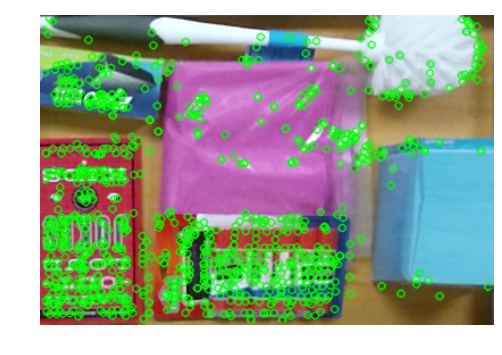

In [5]:
from utils import imread_rgb, compute_sift, draw_keypoints

filename_bin = 'bin/' + bin_stamp + '.png'
image_bin = imread_rgb(filename_bin)
(kp_bin, des_bin) = compute_sift(image_bin)
print('%d features detected in bin' % len(kp_bin))
draw_keypoints(image_bin,kp_bin)

### Optional: apply mask to textured region

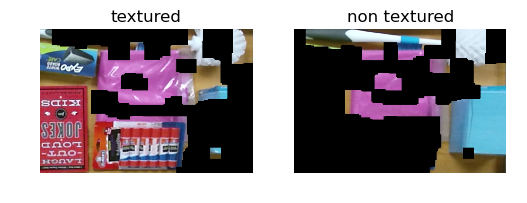

In [6]:
from utils import textured_mask

tx_mask = textured_mask(image_bin, kp_bin)
tx_image =     cv2.bitwise_and(image_bin, image_bin, mask=tx_mask)
non_tx_image = cv2.bitwise_and(image_bin, image_bin, mask=255-tx_mask)
plt.subplot(121), plt.imshow(tx_image),     plt.axis('off'), plt.title('textured');
plt.subplot(122), plt.imshow(non_tx_image), plt.axis('off'), plt.title('non textured');

1034 features detected in bin


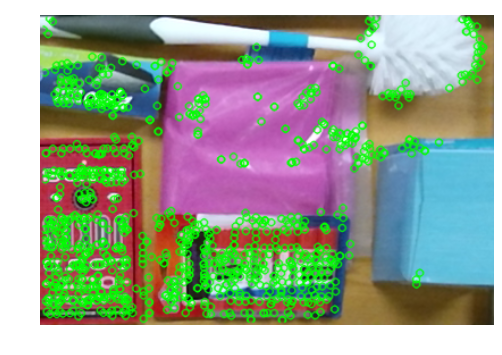

In [7]:
(kp_bin, des_bin) = compute_sift(image_bin, mask=tx_mask)
print('%d features detected in bin' % len(kp_bin))
draw_keypoints(image_bin,kp_bin)

### Match Bin and Items Features

#### First iteration
Compute features for all the items

In [8]:
from utils import read_features_from_file, read_bbox_from_file, unpack_keypoint, calc_matches

items = [s.lower() for s in contents]

Item: "Training items/glue_sticks/glue_sticks_top_01_sift.npy" Good features: 5
Item: "Training items/tissue_box/tissue_box_top_01_sift.npy" Good features: 1
Item: "Training items/laugh_out_loud_jokes/laugh_out_loud_jokes_top_01_sift.npy" Good features: 12
Item: "Training items/toilet_brush/toilet_brush_top_01_sift.npy" Good features: 2
Item: "Training items/expo_eraser/expo_eraser_top_01_sift.npy" Good features: 29
Item: "Training items/table_cloth/table_cloth_top_01_sift.npy" Good features: 3


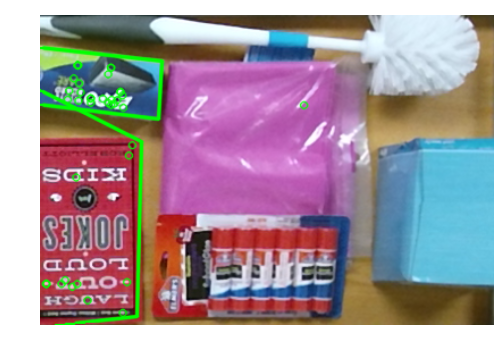

In [9]:
item_d = {}
recognised_items = []
image_disp = image_bin.copy()
mask_bin = np.zeros(image_bin.shape[0:2]).astype('uint8')
for item in items:
    prefix = 'Training items/' + item + '/' + item
    filename = prefix + '_top_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}
    
    filename = prefix + '_bottom_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    if len(good) > len(item_d[item]['good']):
        item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}

    print('Item: "%s" Good features: %d' % (item_d[item]['file'], 
                                          len(item_d[item]['good'])))
    MIN_MATCH_COUNT=10
    kp = item_d[item]['kp']
    good = item_d[item]['good']
    if len(good) > MIN_MATCH_COUNT:
        dst_pts = [ kp_bin[m.trainIdx] for m in good ]
        image_disp = cv2.drawKeypoints(image_disp,dst_pts,color=(0,255,0))
        recognised_items.append(item)
        src_pts = np.float32([ kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_bin[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        #matchesMask = mask.ravel().tolist()
        x, y, w, h = read_bbox_from_file(item_d[item]['file'][:-9] + '_bbox.json')
        pts = np.float32([ [x,y],[x,y+h-1],[x+w-1,y+h-1],[x+w-1,y] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        cv2.polylines(image_disp,[np.int32(dst)],True,(0,255,0),2, cv2.CV_AA)
        cv2.fillConvexPoly(mask_bin,np.int32(dst),(255,))

plt.imshow(image_disp), plt.axis('off');

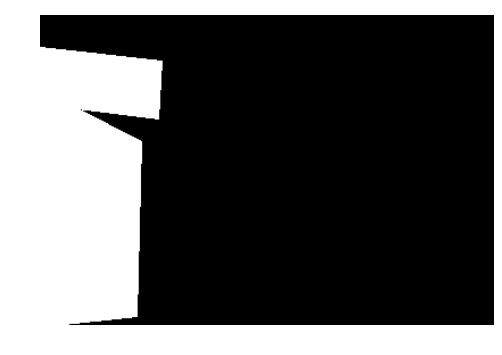

In [10]:
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

#### Second iteration
Refine features in the projection of the items recognised in the first iteration

469 features detected in bin


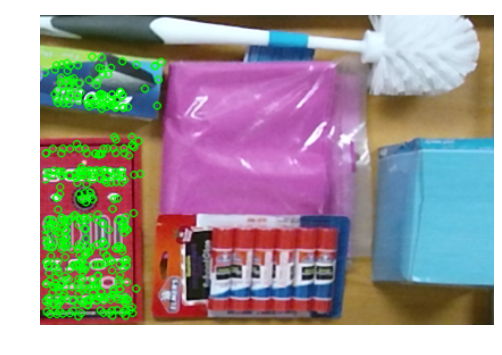

In [11]:
(kp_bin, des_bin) = compute_sift(image_bin, mask=mask_bin)
print('%d features detected in bin' % len(kp_bin))
draw_keypoints(image_bin,kp_bin)

In [12]:
items = recognised_items

Item: "Training items/laugh_out_loud_jokes/laugh_out_loud_jokes_top_01_sift.npy" Good features: 16
Item: "Training items/expo_eraser/expo_eraser_top_01_sift.npy" Good features: 29


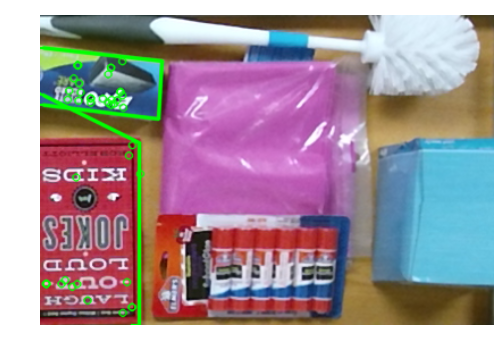

In [13]:
item_d = {}
recognised_items = []
image_disp = image_bin.copy()
mask_bin = np.zeros(image_bin.shape[0:2]).astype('uint8')
for item in items:
    prefix = 'Training items/' + item + '/' + item
    filename = prefix + '_top_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}
    
    filename = prefix + '_bottom_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    if len(good) > len(item_d[item]['good']):
        item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}

    print('Item: "%s" Good features: %d' % (item_d[item]['file'], 
                                          len(item_d[item]['good'])))
    MIN_MATCH_COUNT=10
    kp = item_d[item]['kp']
    good = item_d[item]['good']
    if len(good) > MIN_MATCH_COUNT:
        dst_pts = [ kp_bin[m.trainIdx] for m in good ]
        image_disp = cv2.drawKeypoints(image_disp,dst_pts,color=(0,255,0))
        recognised_items.append(item)
        src_pts = np.float32([ kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_bin[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        x, y, w, h = read_bbox_from_file(item_d[item]['file'][:-9] + '_bbox.json')
        pts = np.float32([ [x,y],[x,y+h-1],[x+w-1,y+h-1],[x+w-1,y] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        cv2.polylines(image_disp,[np.int32(dst)],True,(0,255,0),2, cv2.CV_AA)
        cv2.fillConvexPoly(mask_bin,np.int32(dst),(255,))

plt.imshow(image_disp), plt.axis('off');

laugh_out_loud_jokes recognised with 16 features
         expo_eraser recognised with 29 features


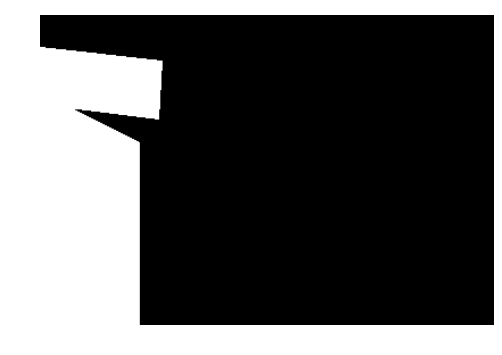

In [14]:
for it in recognised_items:
    print('%20s recognised with %d features' %(it, len(item_d[it]['good'])))
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

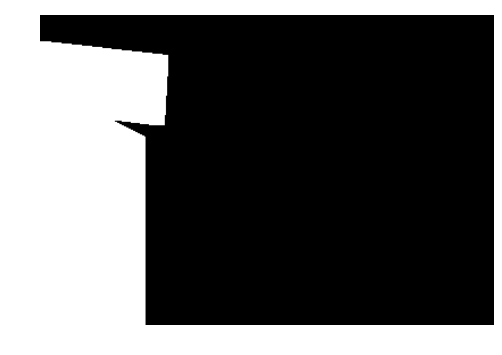

In [15]:
kernel = np.ones((3,3),np.uint8)
mask_bin = cv2.dilate(mask_bin,kernel,iterations = 5)
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

## Phase 2: Recognition by Color

CPU times: user 352 ms, sys: 0 ns, total: 352 ms
Wall time: 351 ms


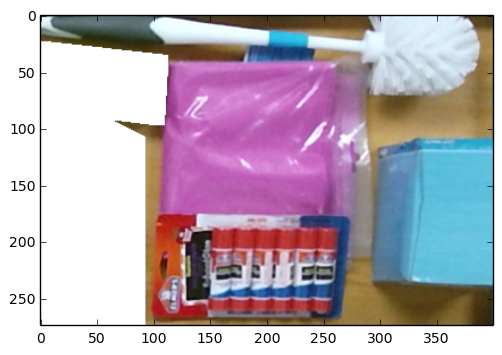

In [21]:
%%time
from sklearn.cluster import KMeans, MiniBatchKMeans

n_cc = 20
image_RGBA = np.dstack((image_bin, 255-mask_bin))
pixels = image_RGBA.reshape((image_RGBA.shape[0] * image_RGBA.shape[1], 4))
filtered_pixels = np.array(filter(lambda x:x[3]==255,pixels))
n, _ = filtered_pixels.shape
pixels_LAB = cv2.cvtColor(filtered_pixels[:,0:3].reshape(1,n,3),cv2.COLOR_RGB2LAB)
pixels_LAB = pixels_LAB.reshape(n,3)
clt = MiniBatchKMeans(n_clusters = n_cc)
clt.fit(pixels_LAB)
plt.imshow(image_RGBA);

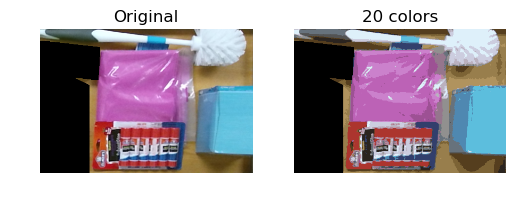

In [22]:
image = cv2.cvtColor(image_bin, cv2.COLOR_RGB2LAB)
(h_bin, w_bin) = image.shape[:2]
pixels = image.reshape((image.shape[0] * image.shape[1], 3))
labels = clt.predict(pixels)
quant = clt.cluster_centers_.astype("uint8")[labels]
quant = quant.reshape((h_bin, w_bin, 3))
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
plt.subplot(121),plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=255-mask_bin)),plt.title('Original'),plt.axis('off');
plt.subplot(122),plt.imshow(cv2.bitwise_and(quant,quant,mask=255-mask_bin)),plt.title('%d colors' % n_cc),plt.axis('off');
bin_cc = clt.cluster_centers_

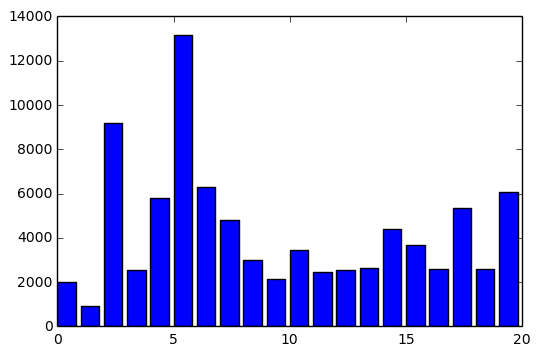

In [23]:
h, _ = np.histogram(clt.predict(pixels_LAB),bins=range(n_cc+1))
plt.bar(range(n_cc), h);

In [24]:
sort_index = np.argsort(h)[::-1]
sort_index

array([ 5,  2,  6, 19,  4, 17,  7, 14, 15, 10,  8, 13, 18, 16,  3, 12, 11,
        9,  0,  1])

In [39]:
obj_label = sort_index[0]
d_other = [np.linalg.norm(bin_cc[5,1:]-other[1:]) for other in bin_cc]
obj_labels = [idx for idx,val in enumerate(d_other) if val<20]
obj_labels

[5, 17, 18]

In [42]:
sort_index = np.array([x for x in sort_index if x not in obj_labels])
sort_index

array([ 2,  6, 19,  4,  7, 14, 15, 10,  8, 13, 16,  3, 12, 11,  9,  0,  1])

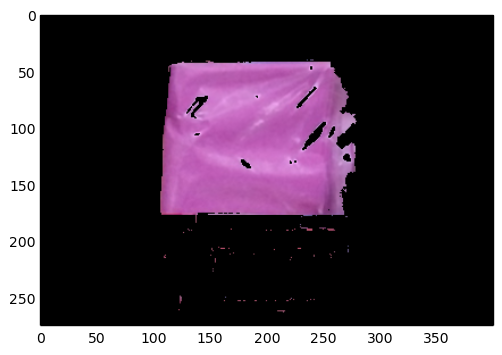

In [40]:
mask = np.zeros((h_bin, w_bin)).astype('uint8')
for val_label in obj_labels:
    mask = cv2.bitwise_or( mask, ((labels==val_label).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_and( mask, 255-mask_bin)
plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=mask));

In [31]:
d_other = [np.linalg.norm(bin_cc[2,1:]-other[1:]) for other in bin_cc]
[idx for idx,val in enumerate(d_other) if val<20]

[2, 10]

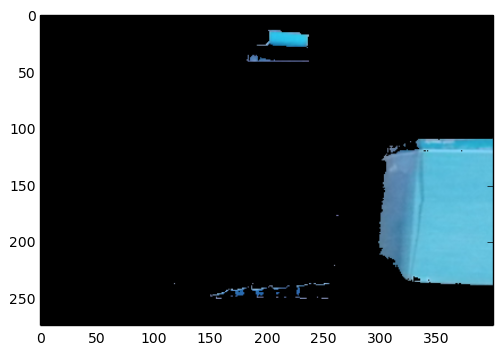

In [32]:
mask = ((labels==2).astype('uint8') * 255).reshape((h_bin, w_bin))
mask = cv2.bitwise_or( mask, ((labels==10).astype('uint8') * 255).reshape((h_bin, w_bin)) )
#mask = cv2.bitwise_or( mask, ((labels==5).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_and( mask, 255-mask_bin)
plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=mask));

In [34]:
d_other = [np.linalg.norm(bin_cc[6,1:]-other[1:]) for other in bin_cc]
[idx for idx,val in enumerate(d_other) if val<20]

[3, 6, 8, 9, 19]

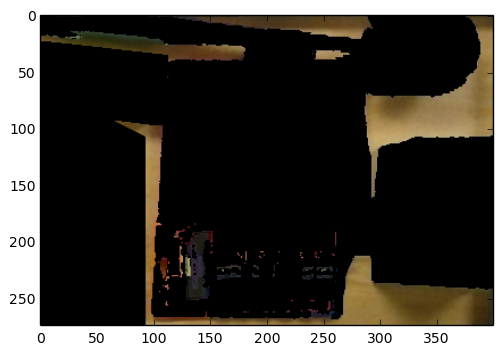

In [35]:
mask = ((labels==6).astype('uint8') * 255).reshape((h_bin, w_bin))
mask = cv2.bitwise_or( mask, ((labels==3).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_or( mask, ((labels==8).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_or( mask, ((labels==9).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_or( mask, ((labels==19).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_and( mask, 255-mask_bin)
plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=mask));

In [36]:
d_other = [np.linalg.norm(bin_cc[4,1:]-other[1:]) for other in bin_cc]
[idx for idx,val in enumerate(d_other) if val<20]

[0, 4, 9, 11, 14, 15, 16]

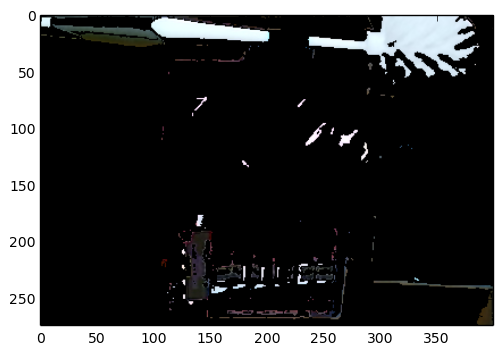

In [37]:
mask = ((labels==4).astype('uint8') * 255).reshape((h_bin, w_bin))
mask = cv2.bitwise_or( mask, ((labels==0).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_or( mask, ((labels==9).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_and( mask, 255-mask_bin)
plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=mask));

In [ ]:
# search the nearest dominant color of items

In [17]:
recognised_items

['laugh_out_loud_jokes', 'expo_eraser']

In [18]:
contents

['glue_sticks',
 'tissue_box',
 'laugh_out_loud_jokes',
 'toilet_brush',
 'expo_eraser',
 'table_cloth']

In [101]:
[contents.remove(it) for it in recognised_items]

[None, None]

In [102]:
contents

['glue_sticks', 'tissue_box', 'toilet_brush', 'table_cloth']

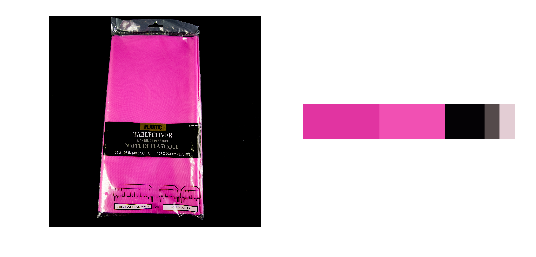

In [81]:
from utils import plot_colors, read_json

item = 'table_cloth'
#item = 'tissue_box'
#item = 'toilet_brush'
#item = 'glue_sticks'

view = 'top_01'
#view = 'top-side_01'
#view = 'bottom_01'

prefix = ITEM_FOLDER + '/' + item + '/' + item + '_' + view
filename = prefix + '.png'
image_RGB = imread_rgb(filename)
if not image_RGB is None:
    #with open(filename[:-4] + '_dc.json', 'r') as infile:
    #    dc = json.load(infile)
    dc = read_json(filename[:-4] + '_dc.json')
    hist = dc['hist']
    cc = dc['cluster_centers']
    bar = plot_colors(hist, cc)
    plt.subplot(121); plt.imshow(image_RGB); plt.axis('off');
    plt.subplot(122); plt.imshow(bar); plt.axis('off');
    obj_cc = cc

In [82]:
d = []
obj_col = obj_cc[0]
for obj_col in obj_cc:
    docc = []
    for idx, bin_col in enumerate(bin_cc):
        dist = np.linalg.norm(bin_col-np.array(obj_col))
        docc.append((dist,idx))
    d.append( sorted(docc)[:5] )
d

[[(27.99061035872305, 2),
  (41.236698648322893, 15),
  (44.297141530949759, 17),
  (67.163396996336616, 16),
  (67.853369809510241, 12)],
 [(29.127439244553315, 2),
  (30.410361341111741, 15),
  (54.602494523055832, 17),
  (68.221341695351384, 16),
  (69.064292118861232, 5)],
 [(33.097350733838873, 11),
  (70.925513342535751, 6),
  (73.70548984269422, 3),
  (99.766394878051443, 9),
  (100.89697732291627, 10)],
 [(23.528626031571324, 3),
  (26.907186276178052, 13),
  (32.206674351640416, 10),
  (32.768472440300748, 6),
  (38.02475215162066, 9)],
 [(13.815831950975971, 8),
  (18.452801524194438, 18),
  (28.774373291623846, 0),
  (43.01789092780529, 7),
  (46.698230875514888, 4)]]

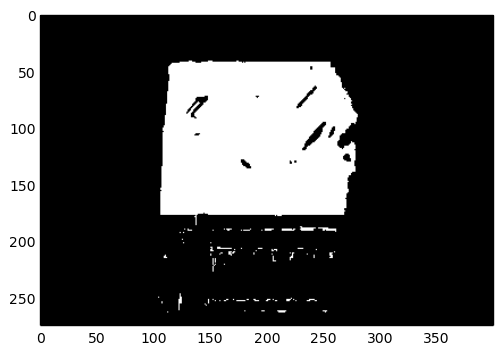

In [86]:
mask = np.zeros(labels.shape).astype('uint8')
# values of first and second DC < 40
for c in [2,15,17]:
    mask_c = np.array([0,255])[(labels==c).astype('uint8')]
    mask = cv2.bitwise_or(mask, mask_c.astype('uint8'))
mask = mask.astype('uint8').reshape((h_bin, w_bin))
mask = cv2.bitwise_and(mask,mask,mask=255-mask_bin)
plt.imshow(mask,cmap='gray');

CPU times: user 745 ms, sys: 0 ns, total: 745 ms
Wall time: 739 ms


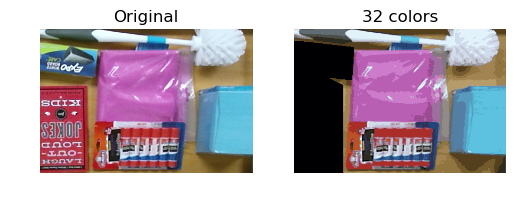

In [14]:
%%time
from sklearn.cluster import KMeans, MiniBatchKMeans

n_cc = 32
image = cv2.bitwise_and(image_bin, image_bin, mask=255-mask_bin)
image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
(h_bin, w_bin) = image.shape[:2]
image = image.reshape((image.shape[0] * image.shape[1], 3))
## remove masked pixels!!!
clt = MiniBatchKMeans(n_clusters = n_cc) # KMeans is more accurate than MiniBatchKMeans, but slower
labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]
quant = quant.reshape((h_bin, w_bin, 3))
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
plt.subplot(121),plt.imshow(image_bin),plt.title('Original'),plt.axis('off');
plt.subplot(122),plt.imshow(quant),plt.title('%d colors' % n_cc),plt.axis('off');
bin_cc = clt.cluster_centers_

In [ ]:
d = []
for bin_col in bin_cc:
    dcol = []
    for obj_col in obj_cc:
        dist = np.linalg.norm(bin_col-np.array(obj_col))
        dcol.append(dist)
    d.append(dcol)
best_col = []
for dcol in d:
    imin = np.argmin(dcol)
    best_col.append((imin,dcol[imin]))
best_col = np.array(best_col)


In [31]:
import glob

#"Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape","Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"
#item = 'Bath_Sponge'
#item = 'Duct_Tape'
#item = 'Burts_Bees_Baby_Wipes'

#item = 'glue_sticks'
#item = 'expo_eraser'
#item = 'laugh_out_loud_jokes'

item = 'Tissue_Box'
#item = 'table_cloth'
#item = 'toilet_brush'

view = 'Top_01'
#view = 'Top-Side_01'
#view = 'Bottom-Side_01'
if item[0].islower():
    item = item.title()

files = glob.glob('Training items/' + item  + '/' + item + '_*.png')
best_cnt = []
for filename in files:    
    image_BGR = cv2.imread(filename)
    image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
    image_RGB = cv2.resize(image_RGB,(600,600))
    #plt.subplot(121); plt.imshow(image_RGB); plt.axis('off');
    with open(filename[:-4] + '_dc.json', 'r') as infile:
        dc = json.load(infile)
    hist = dc['hist']
    cc = dc['cluster_centers']
    #bar = plot_colors(hist, cc)
    #plt.subplot(122); plt.imshow(bar); plt.axis('off'); plt.title(filename); plt.show();
    obj_cc = cc
    d = []
    for bin_col in bin_cc:
        dcol = []
        for obj_col in obj_cc:
            dist = np.linalg.norm(bin_col-np.array(obj_col))
            dcol.append(dist)
        d.append(dcol)
    best_col = []
    for dcol in d:
        imin = np.argmin(dcol)
        best_col.append((imin,dcol[imin]))
    best_col = np.array(best_col)
    n_obj_colors = np.where(np.cumsum(hist) >= 0.66)[0][0]
    active_colors = np.zeros((n_cc,1),dtype=np.uint8)
    for idx_bin_col, val_bin_col in enumerate(best_col):
        if val_bin_col[0] < n_obj_colors and val_bin_col[1] < 30:
            active_colors[idx_bin_col,0] = 255
    mask = active_colors[labels]
    mask = mask.reshape((h_bin, w_bin))
    #plt.imshow(mask,cmap='gray'),plt.axis('off');plt.title(filename);plt.show();
    (cnt,_) = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in cnt:
        ca = cv2.contourArea(c)
        if ca>2000:
            rotrect = cv2.minAreaRect(c)
            ra = rotrect[1][0] * rotrect[1][1]
            if ra>0:
                ratio = ca/ra
                if ratio > 0.5:
                    best_cnt.append((ratio,ca,c,filename))
                
best_cnt = sorted(best_cnt, key=lambda x: x[0], reverse=True)
if len(best_cnt):
    image_cnt = image_bin.copy()
    x,y,w,h = cv2.boundingRect(best_cnt[0][2])
    cv2.rectangle(image_cnt,(x,y),(x+w,y+h),(0,255,0),2)
    plt.imshow(image_cnt),plt.axis('off'),plt.title(best_cnt[0][3]);
    print('Ratio: %.2f, Contour Area: %d' % (best_cnt[0][0],best_cnt[0][1]))
else:
    print('Not found')

Not found


In [166]:
files

['Training items/Glue_Sticks/Glue_Sticks_Bottom-Side_01.png',
 'Training items/Glue_Sticks/Glue_Sticks_Bottom-Side_02.png',
 'Training items/Glue_Sticks/Glue_Sticks_Bottom_01.png',
 'Training items/Glue_Sticks/Glue_Sticks_Top-Side_01.png',
 'Training items/Glue_Sticks/Glue_Sticks_Top-Side_02.png',
 'Training items/Glue_Sticks/Glue_Sticks_Top_01.png']

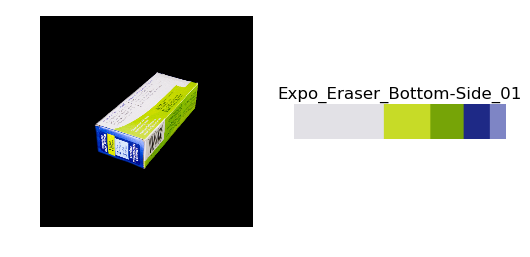

In [172]:
#"Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape","Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"
#item = 'Bath_Sponge'
#item = 'Duct_Tape'
#item = 'Burts_Bees_Baby_Wipes'

#item = 'glue_sticks'
item = 'expo_eraser'
#item = 'laugh_out_loud_jokes'

#item ='Tissue_Box'
#item = 'table_cloth'
#item = 'toilet_brush'

#view = 'Top_01'
#view = 'Top-Side_01'
view = 'Bottom-Side_01'
if item[0].islower():
    item = item.title()
filename = 'Training items/' + item  + '/' + item + '_' + view + '.png'
image_BGR = cv2.imread(filename)
image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
image_RGB = cv2.resize(image_RGB,(600,600))
plt.subplot(121); plt.imshow(image_RGB); plt.axis('off');

with open(filename[:-4] + '_dc.json', 'r') as infile:
    dc = json.load(infile)
hist = dc['hist']
cc = dc['cluster_centers']

bar = plot_colors(hist, cc)
plt.subplot(122); plt.imshow(bar); plt.axis('off'); plt.title(item + '_' + view);
obj_cc = cc

In [118]:
d = []
for bin_col in bin_cc:
    dcol = []
    for obj_col in obj_cc:
        dist = np.linalg.norm(bin_col-np.array(obj_col))
        dcol.append(dist)
    d.append(dcol)

best_col = []
for dcol in d:
    imin = np.argmin(dcol)
    best_col.append((imin,dcol[imin]))
best_col = np.array(best_col)

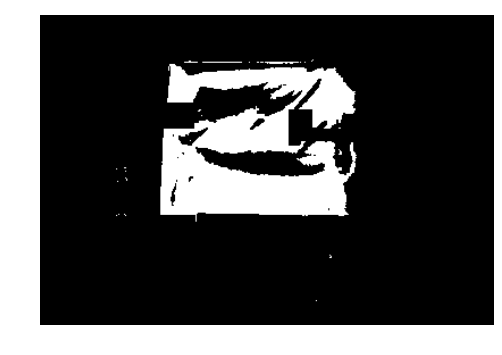

In [120]:
n_obj_colors = np.where(np.cumsum(hist) >= 0.66)[0][0]
#n_obj_colors = 2
active_colors = np.zeros((n_cc,1),dtype=np.uint8)
for idx_bin_col, val_bin_col in enumerate(best_col):
    if val_bin_col[0] < n_obj_colors and val_bin_col[1] < 30:
        active_colors[idx_bin_col,0] = 255
mask = active_colors[labels]
mask = mask.reshape((h_bin, w_bin))
plt.imshow(mask,cmap='gray'),plt.axis('off');

In [104]:
image_cnt = image_bin.copy()

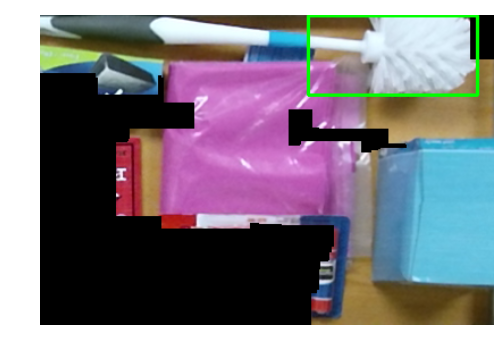

In [105]:
(cnt,_) = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
best_cnt = []
for c in cnt:
    ca = cv2.contourArea(c)
    if ca>2000:
        rotrect = cv2.minAreaRect(c)
        ra = rotrect[1][0] * rotrect[1][1]
        if ra>0:
            ratio = ca/ra
            best_cnt.append((ratio,ca,c))
best_cnt = sorted(best_cnt, key=lambda x: x[0], reverse=True)

if len(best_cnt):
    x,y,w,h = cv2.boundingRect(best_cnt[0][2])
    cv2.rectangle(image_cnt,(x,y),(x+w,y+h),(0,255,0),2)
    plt.imshow(image_cnt),plt.axis('off');
else:
    print('Not found')